In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt


In [2]:
import sys
import os
sys.path.append(os.path.abspath("../scripts"))
try:
    from eda import ExplanatoryAnalysis
except:
    print("import error")

In [3]:
df_bnd = pd.read_csv('C:\\Users\\Aman\\Desktop\\kifyaw11\\Data\\BND_raw_data.csv')
df_spy = pd.read_csv('C:\\Users\\Aman\\Desktop\\kifyaw11\\Data\\SPY_raw_data.csv')
df_tsla = pd.read_csv('C:\\Users\\Aman\\Desktop\\kifyaw11\\Data\\TSLA_raw_data.csv')

In [4]:
bnd_eda = ExplanatoryAnalysis()
spy_eda = ExplanatoryAnalysis()
tsla_eda = ExplanatoryAnalysis()

In [5]:
df_bnd=bnd_eda.to_time(df_bnd, "BND")
df_spy=spy_eda.to_time(df_spy, "SPY")
df_tsla=tsla_eda.to_time(df_tsla, "TSLA")

In [6]:
df_tsla.head()

,Close_TSLA,High_TSLA,Low_TSLA,Open_TSLA,Volume_TSLA
Date,,,,,
2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [8]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test
adf_test = adfuller(df_tsla["Close_TSLA"].dropna())
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")

ADF Statistic: -0.5687280656291531, p-value: 0.8778928052253298


In [9]:
train_size = int(0.8* len(df_tsla))
train_size

2028

In [19]:
df_tsla['Close_TSLA_Diff'] = df_tsla['Close_TSLA'].diff().dropna()
last_close = df_tsla['Close_TSLA'][train_size-1]

C:\Users\Aman\AppData\Local\Temp\ipykernel_11324\1861493119.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_close = df_tsla['Close_TSLA'][train_size-1]


In [11]:
# Train ARIMA on the differenced series
train_data = df_tsla["Close_TSLA_Diff"][:train_size]
test_data = df_tsla[["Close_TSLA"]][train_size:train_size+30]

In [31]:
p, d, q = (2, 1, 2)   # Set based on ACF/PACF analysis
P, D, Q, s = (1, 1, 1, 252)  # Seasonal terms for yearly seasonality in daily data

In [ ]:
sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_result = sarima_model.fit()

c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inv

In [29]:

arima_model = ARIMA(train_data, order=(2,1,2))  # d=1 since we differenced once
arima_result = arima_model.fit()

c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
 

In [27]:
# Forecast next 30 days
forecast_diff = arima_result.forecast(steps=30)
# Get last actual price before forecasting
last_actual_price = last_close  

# Convert differenced predictions back to original scale
forecast_actual = last_actual_price + forecast_diff.cumsum()


c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Aman\Desktop\kifyaw11\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


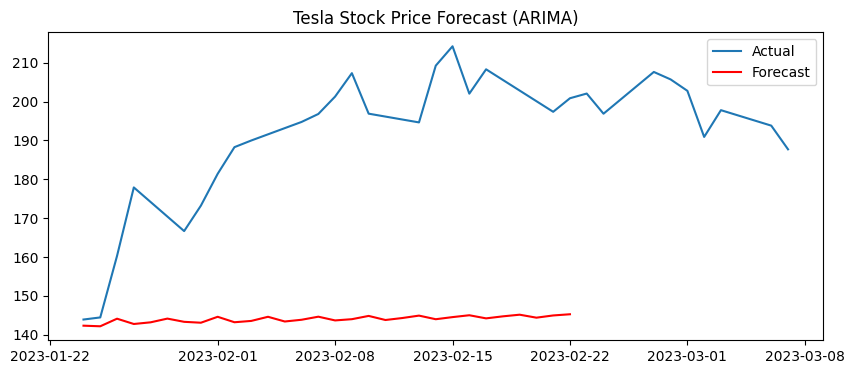

In [24]:

plt.figure(figsize=(10,4))
plt.plot(test_data.index, test_data["Close_TSLA"], label="Actual")
plt.plot(pd.date_range(test_data.index[0], periods=30, freq="D"), forecast_actual, label="Forecast", color="red")
plt.legend()
plt.title("Tesla Stock Price Forecast (ARIMA)")
plt.show()